# <h1 align="center" style="font-family:verdana;"> ⬆️⬆️⬆️ If you find this note book helpful. <b>please upvote!</b> ⬆️⬆️⬆️ </h1>

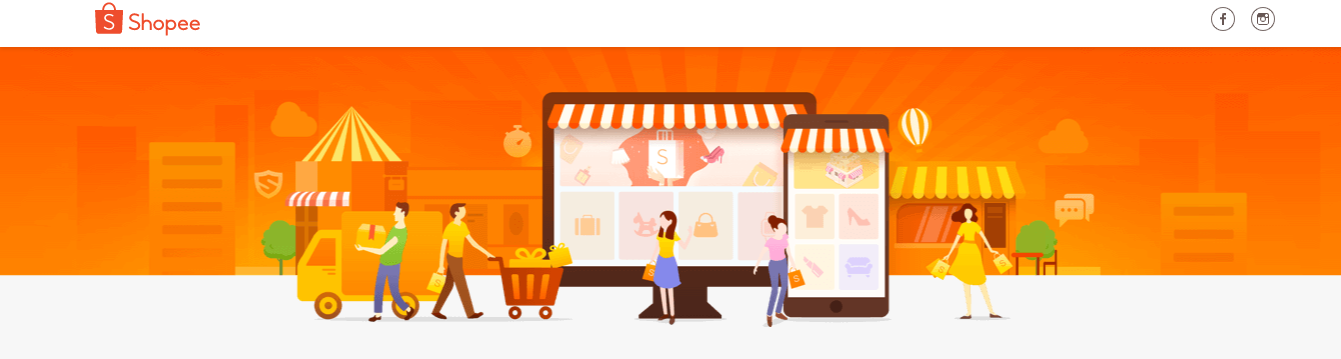

[Competition Link](https://www.kaggle.com/c/shopee-product-matching)

## Problem Statement

Finding near-duplicates in large datasets is an important problem for many online businesses. In Shopee's case, everyday users can upload their own images and write their own product descriptions, adding an extra layer of challenge. Your task is to identify which products have been posted repeatedly. The differences between related products may be subtle while photos of identical products may be wildly different!

In [ ]:
import numpy as np
import pandas as pd
from skimage.io import imread,imshow,imsave
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [ ]:
dir_path = "../input/shopee-product-matching/"
train_dir = dir_path+'train_images/'
test_dir = dir_path+'test_images'

In [ ]:
train_df = pd.read_csv(dir_path+'train.csv')

In [ ]:
train_df.head()

In [ ]:
train_df.shape

In [ ]:
#loading all the images from the training dataset is leading to memory overflow

## Exploring label_group column

**viewing pictures related to same label group**

In [ ]:
print("unique label groups = ",train_df.label_group.nunique())

In [ ]:
label_group_list = random.sample(list(train_df.label_group),5)

In [ ]:
label_group_list

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
for i,lg in enumerate(label_group_list):
    image_names = train_df[train_df.label_group == lg]['image']
    print("label_group = ",lg,"number of images = ",len(image_names))
    for j,img_name in enumerate(image_names):
        if(j>=5): 
            break
        img = plt.imread(train_dir+img_name)
        ax[i,j].imshow(img)

## Exploring phash column 

In [ ]:
train_df['image_phash'].value_counts()

In [ ]:
#feting images with the same phash value
phash_list = train_df['image_phash'].value_counts()[:5].index

In [ ]:
phash_list

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(20,20))
for i,val in enumerate(phash_list):
    image_names = train_df[train_df.image_phash == val]['image']
    print(val,len(image_names))
    for j,img_name in enumerate(image_names):
        if(j>=5): 
            break
        img = plt.imread(train_dir+img_name)
        ax[i,j].imshow(img)

**Images whose phash values are same, are exactly similar**

Let us take few images with same label_group and find the hamming distance of the phash values

In [ ]:
label_group_list

In [ ]:
def hammingDistance(str1, str2) : 
    n1 = int(str1,16)
    n2 = int(str2,16)
  
    x = n1 ^ n2  
    setBits = 0
  
    while (x > 0) : 
        setBits += x & 1
        x >>= 1
      
    return setBits 

In [ ]:
df = train_df[train_df['label_group'] == 4159286058][['image_phash','image']]
phash_values = df['image_phash'].values
image_name = df['image'].values

In [ ]:
# Finding difference of all hashing values
fig, ax = plt.subplots(nrows=3,ncols=2,figsize=(20,20))
k = 0
for i in range(len(phash_values)):
    for j in range(i+1,len(phash_values)):
        img1 = plt.imread(train_dir+image_name[i])
        img2 = plt.imread(train_dir+image_name[j])
        ax[k,0].imshow(img1)
        ax[k,1].imshow(img2)
        k = k+1
        print("phash 1 - ",phash_values[i],
              "phash 2 - ",phash_values[j],
              "hamming distance - ",hammingDistance(phash_values[i],phash_values[j]))

**We see that for similar images, hamming distance of phash values are close.**

**After checking multiple images, I saw that images with hamming distance <= 32 are very similar**

Let us find minimum and maximum values of hamming distance in a Label group.

In [ ]:
label_group_list = random.sample(list(train_df.label_group),100)  #taking 100 random label_group

In [ ]:
min_hamming_list = []
max_hamming_list = []
for lg in label_group_list:
    phash_values = train_df[train_df['label_group'] == lg]['image_phash'].values
    min_hamming_value = 65
    max_hamming_value = -1
    for p1 in range(len(phash_values)):
        for p2 in range(p1+1,len(phash_values)):
            hd = hammingDistance(phash_values[p1],phash_values[p2])
            min_hamming_value = min(min_hamming_value,hd)
            max_hamming_value = max(max_hamming_value,hd)
    min_hamming_list.append(min_hamming_value)
    max_hamming_list.append(max_hamming_value)
            

In [ ]:
hamming_df = pd.DataFrame({'maximum Hamming Distance':max_hamming_list,
              'minimum Hamming Distance':min_hamming_list})

In [ ]:
sns.boxplot(y="maximum Hamming Distance",data=hamming_df)

In [ ]:
sns.boxplot(y="minimum Hamming Distance",data=hamming_df)

**Hamming Distance of phash values could be an importance Feature in grouping Images.**

## Exploring title column 

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
label_group_list = random.sample(list(train_df.label_group),100)  #taking 100 random label_group

In [ ]:
title_df = train_df[train_df['label_group'].isin(label_group_list)][['label_group','title']]
title_df.reset_index(drop=True,inplace=True)

In [ ]:
title_df.head()

In [ ]:
sentence_embeddings = sbert_model.encode(title_df.title.values)

In [ ]:
print('BERT embedding vector - length', len(sentence_embeddings[0]))

In [ ]:
title_df['embeddings'] = title_df.index.map(mapper=(lambda i:sentence_embeddings[i]))

In [ ]:
title_df.head()

In [ ]:
lg = random.choice(label_group_list)

In [ ]:
#checking cosine similarity within a label group
sample_df = title_df[title_df.label_group == lg][['title','embeddings']]
embedding_vectors = sample_df['embeddings'].values
titles = sample_df['title'].values

In [ ]:
from scipy.spatial.distance import cosine

In [ ]:
for i in range(len(embedding_vectors)):
    for j in range(i+1,len(embedding_vectors)):
        print("cosine similaity between ",titles[i]," and \n",titles[j]," = ",
              cosine(embedding_vectors[i], embedding_vectors[j]))
        print("\n")

**Finding Minimum and Maximum Cosine Similarities within Label Groups**

In [ ]:
min_sim_list = []
max_sim_list = []
for lg in label_group_list:
    sample_df = title_df[title_df.label_group == lg][['title','embeddings']]
    embedding_vectors = sample_df['embeddings'].values
    titles = sample_df['title'].values
    min_sim_value = 2
    max_sim_value = -1
    for i in range(len(embedding_vectors)):
        for j in range(i+1,len(embedding_vectors)):
            cosine_sim_val = cosine(embedding_vectors[i], embedding_vectors[j])
            min_sim_value = min(min_sim_value,cosine_sim_val)
            max_sim_value = max(max_sim_value,cosine_sim_val)
    min_sim_list.append(min_sim_value)
    max_sim_list.append(max_sim_value)
            

In [ ]:
similarity_df = pd.DataFrame({'maximum cosine similarity':max_sim_list,
              'minimum cosine similarity':min_sim_list})

In [ ]:
sns.boxplot(y="maximum cosine similarity",data=similarity_df)

In [ ]:
sns.boxplot(y="minimum cosine similarity",data=similarity_df)

**Cosine Similarity Between titles of images can be used for image grouping**

### **Stay tuned for more!**